In [1]:
# Installation commands included for the sake of compatibility, feel free to comment them out
%pip install pandas
%pip install numpy
%pip install nltk
%pip install spacy
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install scikit-learn
%pip install kagglehub
%pip install gensim
%pip install scipy==1.12
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import nltk
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import en_core_web_sm
import kagglehub
import gensim
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oscho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Download latest version
path = kagglehub.dataset_download("abisheksudarshan/topic-modeling-for-research-articles")
print("Path to dataset files:", path)

# Load datasets
train_df = pd.read_csv(path + '\\' + 'Train.csv')
test_df = pd.read_csv(path + '\\' + 'Test.csv')

# train_df
# test_df

Path to dataset files: C:\Users\oscho\.cache\kagglehub\datasets\abisheksudarshan\topic-modeling-for-research-articles\versions\7


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text Preprocessing
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters
    # text = re.sub(r'\W', ' ', text) # Alternative removal method
    words = word_tokenize(text) # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Lemmatization & stopword removal
    return ' '.join(words)

# Apply preprocessing
train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(preprocess_text)
test_df['ABSTRACT'] = test_df['ABSTRACT'].apply(preprocess_text)

In [4]:
# First attempt at TF-IDF Vectorization
# def vectorize_text(df, text_column):
#     vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1,2))
#     tfidf_matrix = vectorizer.fit_transform(df[text_column])
#     return tfidf_matrix, vectorizer

# tfidf_matrix, vectorizer = vectorize_text(test_df, 'ABSTRACT')


# TF-IDF Vectorization for both train and test
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_df['ABSTRACT'])
X_test_tfidf = vectorizer.transform(test_df['ABSTRACT'])

In [5]:
# K-Means Clustering
def apply_kmeans(tfidf_matrix, num_clusters=30):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    silhouette = silhouette_score(tfidf_matrix, clusters)
    return clusters, kmeans, silhouette

clusters, kmeans_model, silhouette = apply_kmeans(X_test_tfidf)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.07669926896932903


In [6]:
# First attempt at Naive Bayes Classification that
# spat out 0 because of wildly misdirected training
# def train_naive_bayes(train_df, test_df, text_column, label_column):
#     X_train, X_test, y_train, y_test = train_df[text_column], test_df[text_column], train_df[label_column], test_df[label_column]
#     vectorizer = TfidfVectorizer()
#     X_train_tfidf = vectorizer.fit_transform(X_train)
#     X_test_tfidf = vectorizer.transform(X_test)
#     model = MultinomialNB()
#     model.fit(X_train_tfidf, y_train)
#     predictions = model.predict(X_test_tfidf)
#     accuracy = accuracy_score(y_test, predictions)
#     return model, accuracy

# model, accuracy = train_naive_bayes(train_df, test_df, 'ABSTRACT', 'ABSTRACT')
# print(f"Naive Bayes Classification Accuracy: {accuracy}")


# Attempt #2: It could be better, but it's good enough
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# Get common tag columns in both Train and Test
common_tags = list(set(train_df.columns[2:]) & set(test_df.columns[2:]))  
common_tags.sort()  # Ensure consistent order

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['ABSTRACT'])
X_test_tfidf = vectorizer.transform(test_df['ABSTRACT'])

# Extract multi-label outputs (Y values) for common tags
y_train = train_df[common_tags].values
y_test = test_df[common_tags].values

# Train Multi-Label Naive Bayes Model
model = OneVsRestClassifier(MultinomialNB())
model.fit(X_train_tfidf, y_train)

# Predictions and Accuracy
predictions = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)

print(f"Multi-Label Naive Bayes Accuracy: {accuracy:.4f}")

Multi-Label Naive Bayes Accuracy: 0.5638


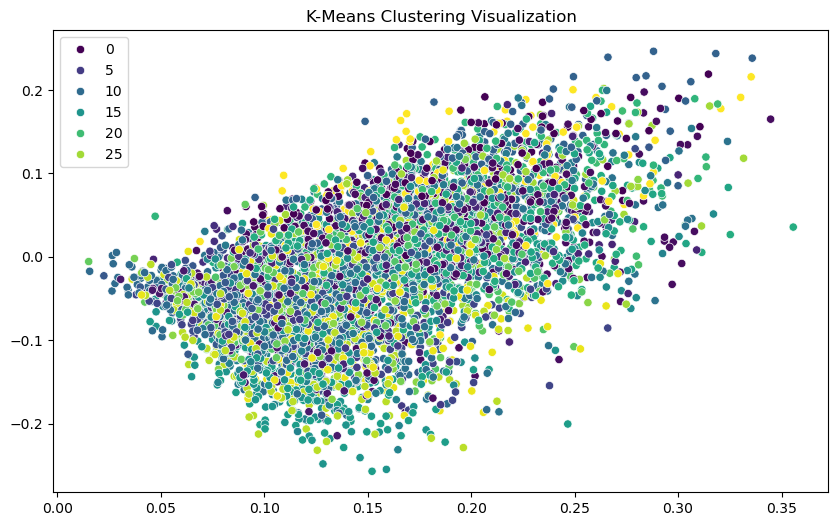

In [7]:
# # Visualization
# def visualize_clusters(tfidf_matrix, clusters):
#     pca = PCA(n_components=2)
#     reduced_data = pca.fit_transform(tfidf_matrix.toarray())
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=clusters, palette='viridis')
#     plt.title("K-Means Clustering Visualization")
#     plt.show()


from sklearn.decomposition import TruncatedSVD

def visualize_clusters(tfidf_matrix, clusters):
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_data = svd.fit_transform(tfidf_matrix)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=clusters, palette='viridis')
    plt.title("K-Means Clustering Visualization")
    plt.show()


visualize_clusters(X_test_tfidf, clusters)

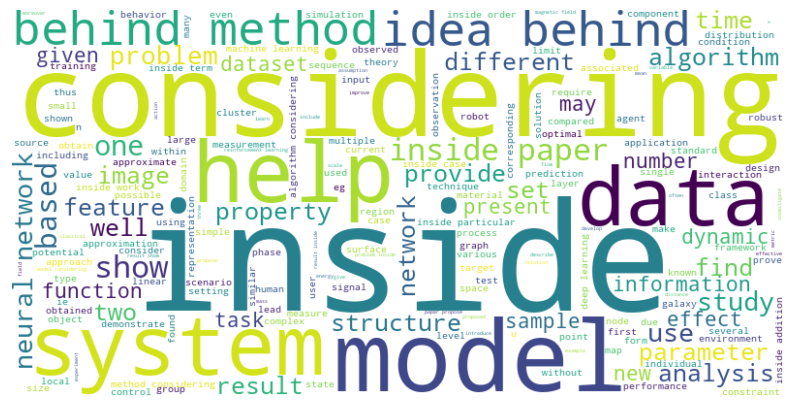

In [8]:
# Visualization 2: Electric Boogaloo
def generate_wordcloud(text_data):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(train_df['ABSTRACT'])

In [9]:
# Convert text to bag-of-words for LDA
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.1, stop_words='english')
X_train_bow = count_vectorizer.fit_transform(train_df['ABSTRACT'])

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(X_train_bow)

# Extract words for each topic
def get_topics(lda_model, vectorizer, top_n=10):
    terms = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda_model.components_):
        topics[f"Topic {idx+1}"] = [terms[i] for i in topic.argsort()[-top_n:]]
    return topics

topic_words = get_topics(lda_model, count_vectorizer)
for topic, words in topic_words.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: based, use, set, help, paper, result, considering, information, space, feature
Topic 2: state, based, performance, paper, result, proposed, help, framework, considering, time
Topic 3: proposed, based, propose, process, result, data, help, parameter, considering, model
Topic 4: present, use, technique, used, new, method, help, analysis, considering, data
Topic 5: based, propose, performance, paper, proposed, number, problem, learning, considering, algorithm
Topic 6: new, help, structure, study, result, property, order, state, field, considering
Topic 7: paper, result, propose, method, performance, considering, task, neural, learning, network
Topic 8: result, number, study, different, parameter, simulation, process, considering, structure, distribution
Topic 9: study, given, set, paper, case, result, function, solution, problem, considering
Topic 10: approach, paper, help, propose, function, based, proposed, considering, idea, method


In [10]:
# Compute coherence score
texts = [doc.split() for doc in train_df['ABSTRACT']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
gensim_lda = gensim.models.LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes=10)
coherence_model = CoherenceModel(model=gensim_lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"LDA Coherence Score: {coherence_score}")

LDA Coherence Score: 0.45289682257919794
